In [1]:
import glob
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from math import sqrt
import string
import warnings
warnings.filterwarnings("ignore")

In [2]:
models = ["CESM2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1","FGOALS-f3-L",
          "FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L","MPI-ESM1-2-HR",
          "MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1"]
# Initialize DataFrames
model_year = pd.DataFrame({'model': models, '1.5': '/', '2': '/', '3': '/', '4': '/'})
model_tas = pd.DataFrame({'model': models, 'his': np.nan, '1.5': '/', '2': '/', '3': '/', '4': '/'})

# Load data function
def load_nc_data(filepath):
    with Dataset(filepath) as file:
        return file["tas"][:]

# Calculate annual average
def calculate_annual_average(data):
    return np.mean(data.reshape(-1, 12), axis=1)

# Process each model's data
window_size = 20
for model in models:
    # Load and calculate pre-industrial and historical means
    tas_pre = load_nc_data(glob.glob(f'/home/wangjx/cmip6_global_tas_1850_1900_monthly/{model}_*.nc')[0])
    pre_mean = tas_pre.mean()
    
    tas_his = load_nc_data(glob.glob(f'/home/wangjx/cmip6_global_tas_1982_2014_monthly/{model}_*.nc')[0])
    his_mean = tas_his.mean()
    model_tas.loc[model_tas['model'] == model, 'pre'] = pre_mean
    model_tas.loc[model_tas['model'] == model, 'his'] = his_mean

    # Load future data and concatenate with historical annual averages
    tas_future = load_nc_data(glob.glob(f'/home/wangjx/cmip6_global_tas_2015_2100_monthly_ssp245/{model}_*.nc')[0])
    annual_tas = np.concatenate([calculate_annual_average(tas_his), calculate_annual_average(tas_future)])
    
    # Determine temperature thresholds
    thresholds_found = {'1.5': False, '2': False, '3': False, '4': False}
    for start_idx in range(len(annual_tas) - window_size + 1):
        avg_20_years = annual_tas[start_idx:start_idx + window_size].mean()
        difference = avg_20_years - pre_mean
        start_year = 1982 + start_idx

        for threshold in ['1.5', '2', '3', '4']:
            if not thresholds_found[threshold] and difference > float(threshold):
                model_year.loc[model_year['model'] == model, threshold] = f"[{start_year},{start_year + window_size - 1}]"
                model_tas.loc[model_tas['model'] == model, threshold] = avg_20_years
                thresholds_found[threshold] = True

        if all(thresholds_found.values()):
            break

print(model_year)

            model          1.5            2            3  4
0           CESM2  [2017,2036]  [2032,2051]  [2071,2090]  /
1     CESM2-WACCM  [2015,2034]  [2030,2049]  [2066,2085]  /
2   CNRM-CM6-1-HR  [2010,2029]  [2024,2043]  [2053,2072]  /
3      CNRM-CM6-1  [2021,2040]  [2039,2058]  [2075,2094]  /
4     CNRM-ESM2-1  [2028,2047]  [2046,2065]  [2079,2098]  /
5     FGOALS-f3-L  [2012,2031]  [2031,2050]            /  /
6       FGOALS-g3  [2021,2040]  [2054,2073]            /  /
7        GFDL-CM4  [2022,2041]  [2040,2059]            /  /
8       GFDL-ESM4  [2037,2056]  [2064,2083]            /  /
9          MIROC6  [2037,2056]  [2064,2083]            /  /
10     MIROC-ES2L  [2032,2051]  [2054,2073]            /  /
11  MPI-ESM1-2-HR  [2028,2047]  [2054,2073]            /  /
12  MPI-ESM1-2-LR  [2027,2046]  [2048,2067]            /  /
13     NorESM2-LM  [2046,2065]  [2076,2095]            /  /
14     NorESM2-MM  [2037,2056]  [2069,2088]            /  /
15        TaiESM1  [2022,2041]  [2034,20

In [4]:
letters = list(string.ascii_lowercase) 
def plot_sensitivity(obsmean, obsstd, ss, fs, model, i, j):
    # Convert input ss and fs to numpy arrays
    ss = np.array(ss, dtype=np.float64)
    fs = np.array(fs, dtype=np.float64).flatten()
    # Create DataFrame and sort
    df = pd.DataFrame({'x': ss, 'y': fs})
    df = df.dropna().reset_index(drop=True)
    ss = df['x']
    fs = df['y']
    df = df.sort_values('x')

    # Perform linear regression
    ols_model = ols('y ~ x', data=df).fit()
    r, p_value = pearsonr(ss, fs)
    pred = ols_model.get_prediction(df)
    pred_summary = pred.summary_frame(alpha=0.05)

    xmean = np.mean(ss)
    xstd = np.std(ss)
    zmean = np.mean(fs)
    zstd = np.std(fs)
    print('zmean = ' + str(round(zmean, 2)))
    print('zstd = ' + str(round(zstd, 2)))
    
    # Calculate the forecasted value with emerging constraints
    zmean_EC = zmean + r * zstd * xstd * (obsmean - xmean) / (xstd**2 + obsstd**2)
    zstd_EC = sqrt(1 - r**2 / (1 + obsstd**2 / xstd**2)) * zstd
    print('zmean_EC = ' + str(round(zmean_EC, 4)))
    print('zstd_EC = ' + str(round(zstd_EC, 4)))
    print('RCM ' +str(round(((zmean_EC-zmean)/zmean)*100,2))+'%')
    print('RRV ' +str(round((1-zstd_EC*zstd_EC/zstd/zstd)*100,2))+'%')
    
    tem = ["1.5°C", "2°C", "3°C"]
    row_title = ["1.6m", "2.4m", "3.2m"]
    print((model_tas[tem[i][:-2]].mean()-model_tas['his'].mean())*zmean_EC)
    print((model_tas[tem[i][:-2]].mean()-model_tas['his'].mean())*zstd_EC)

    ax = axs[i, j]
    # Set labels for subplots
    ax.text( -0.18, 1.04, 
            f"{letters[3*i+j]}",
            transform=ax.transAxes, 
            fontproperties=FontProperties(weight='bold', size=11), 
            verticalalignment='bottom',
            color='black')
    if i == 1 and j == 1:
        x_labels = ["Seasonal sensitivity of soil temperature (°C/°C)"]
        ax.set_xlabel(x_labels[0], labelpad=12, fontsize=14)
    if i == 1 and j == 0:
        y_labels = ["Sensitivity of permafrost loss to global warming (%/°C)"]
        ax.set_ylabel(y_labels[0], labelpad=43, fontsize=14)
        ax.yaxis.set_label_coords(-0.5, 1.1)
    if i == 0:
        ax.set_title(row_title[j], fontsize=12, c='black')
    if j == 0:
        ax.text(-0.27, 0.5, tem[i], va='center', ha='right', rotation='vertical', 
                   fontsize=12, transform=ax.transAxes)  # Adjust to fit layout
    
    colors = plt.cm.tab20b(np.linspace(0, 1, 20)) # Generate color list using colormap
    markers = ['o', 's', '^']
    
    ax.plot(df['x'].values, pred_summary['mean'].values, color='blue', linewidth=2)
    print("sucess")
    ax.fill_between(df['x'], pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='blue', alpha=0.2)
    # Plot scatter plot
    h = 0
    for s, f, color, mod in zip(ss, fs, colors, model):
        if h % 3 == 0:
            ax.scatter(s, f, color=color, marker=markers[0], s=19, label=mod)
        elif h % 3 == 1:
            ax.scatter(s, f, color=color, marker=markers[1], s=19, label=mod)
        else:
            ax.scatter(s, f, color=color, marker=markers[2], s=19, label=mod)
        h = h + 1

    if j == 0:
        ax.set_ylim(-112,0)
        ax.set_xlim(0.18,0.61)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(4))
        ax.yaxis.set_major_locator(plt.MultipleLocator(20))
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', length=2, color='black')
        ax.plot([np.max(ss) + 0.02, np.max(ss) + 0.02], [zmean - zstd, zmean + zstd], color='blue', linewidth=2)
        ax.scatter(np.max(ss) + 0.02, zmean, color='blue', s=30)
        ax.scatter(np.max(ss) + 0.035, zmean_EC, color='black', s=30)
        ax.plot([np.max(ss) + 0.035, np.max(ss) + 0.035], [zmean_EC - zstd_EC, zmean_EC + zstd_EC], color='black', linewidth=2)
    elif j == 1:
        ax.set_ylim(-65, -5)
        ax.set_xlim(0.13,0.44)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(plt.FixedLocator(np.arange(-65, -5, 2)))
        ax.yaxis.set_major_locator(plt.MultipleLocator(10))
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', length=2, color='black')
        ax.set_yticks(np.arange(-70, -5, 10) + 5)
        ax.set_yticklabels([str(m) for m in range(-65, 0, 10)], color='black')
        ax.plot([np.max(ss) + 0.019, np.max(ss) + 0.019], [zmean - zstd, zmean + zstd], color='blue', linewidth=2)
        ax.scatter(np.max(ss) + 0.019, zmean, color='blue', s=30)
        ax.scatter(np.max(ss) + 0.031, zmean_EC, color='black', s=30)
        ax.plot([np.max(ss) + 0.031, np.max(ss) + 0.031], [zmean_EC - zstd_EC, zmean_EC + zstd_EC], color='black', linewidth=2)
    else:
        ax.set_ylim(-50,-5)
        ax.set_xlim(0.1,0.356)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(plt.FixedLocator(np.arange(-49, -5, 2)))
        ax.yaxis.set_major_locator(plt.MultipleLocator(10))
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', length=2, color='black')
        ax.set_yticks(np.arange(-50, -5, 10) + 5)
        ax.set_yticklabels([str(m) for m in range(-45, 0, 10)], color='black') 
        ax.plot([np.max(ss) + 0.015, np.max(ss) + 0.015], [zmean - zstd, zmean + zstd], color='blue', linewidth=2)
        ax.scatter(np.max(ss) + 0.015, zmean, color='blue', s=30)
        ax.scatter(np.max(ss) + 0.025, zmean_EC, color='black', s=30)
        ax.plot([np.max(ss) + 0.025, np.max(ss) + 0.025], [zmean_EC - zstd_EC, zmean_EC + zstd_EC], color='black', linewidth=2)
    ylim = ax.get_ylim()
    ax.plot([obsmean, obsmean], [ylim[0], ylim[0] + 0.94 * (ylim[1] - ylim[0])], color='black', linewidth=1.5, linestyle='--')
    ax.text(obsmean, ylim[0] + 0.97 * (ylim[1] - ylim[0]), "obs", ha='center', va='center', fontsize=10)
    ax.fill_betweenx([ylim[0], ylim[0] + 0.94 * (ylim[1] - ylim[0])], obsmean - obsstd, obsmean + obsstd, color='gray', alpha=0.3)        
    ax.set_ylim(ylim[0], ylim[1])  # Set y-axis range from 0 to 12
    
    if i == 1 and j == 1:
        # Set legend
        ax.legend(loc='upper center', bbox_to_anchor=(0.3, -0.3), edgecolor='lightgrey', shadow=False, ncol=6)
    print(p_value)
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    else:
        significance = ''  # Do not display asterisks when the result is not statistically significant

    # Add correlation coefficient and statistical significance to the plot
    ax.text(0.045, 0.1,f"$R = {r:.2f}${significance}", ha='left', va='center', transform=ax.transAxes, fontsize=10)
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.3)
    return fig

zmean = -40.12
zstd = 23.1
zmean_EC = -49.8476
zstd_EC = 15.478
RCM 24.24%
RRV 55.09%
-45.43020209066312
14.106361978490847
sucess
0.0009207243021185205
zmean = -37.36
zstd = 15.42
zmean_EC = -44.2111
zstd_EC = 9.5893
RCM 18.33%
RRV 61.32%
-62.33675457281147
13.520760915488793
sucess
0.0003033441414168928
zmean = -26.56
zstd = 11.76
zmean_EC = -32.7148
zstd_EC = 8.8556
RCM 23.16%
RRV 43.29%
-29.815674422252613
8.070806529063589
sucess
0.004877381805343224
zmean = -27.79
zstd = 10.87
zmean_EC = -34.2498
zstd_EC = 7.2265
RCM 23.25%
RRV 55.84%
-48.29155723329308
10.189199311510231
sucess
0.0007028414604759267
zmean = -22.43
zstd = 9.62
zmean_EC = -24.6248
zstd_EC = 6.7544
RCM 9.8%
RRV 50.66%
-22.442637824488273
6.155840481092159
sucess
0.0018074308306866504
zmean = -23.74
zstd = 9.12
zmean_EC = -25.9533
zstd_EC = 5.9632
RCM 9.33%
RRV 57.24%
-36.5935512567451
8.408029009280613
sucess
0.0006144309199543386


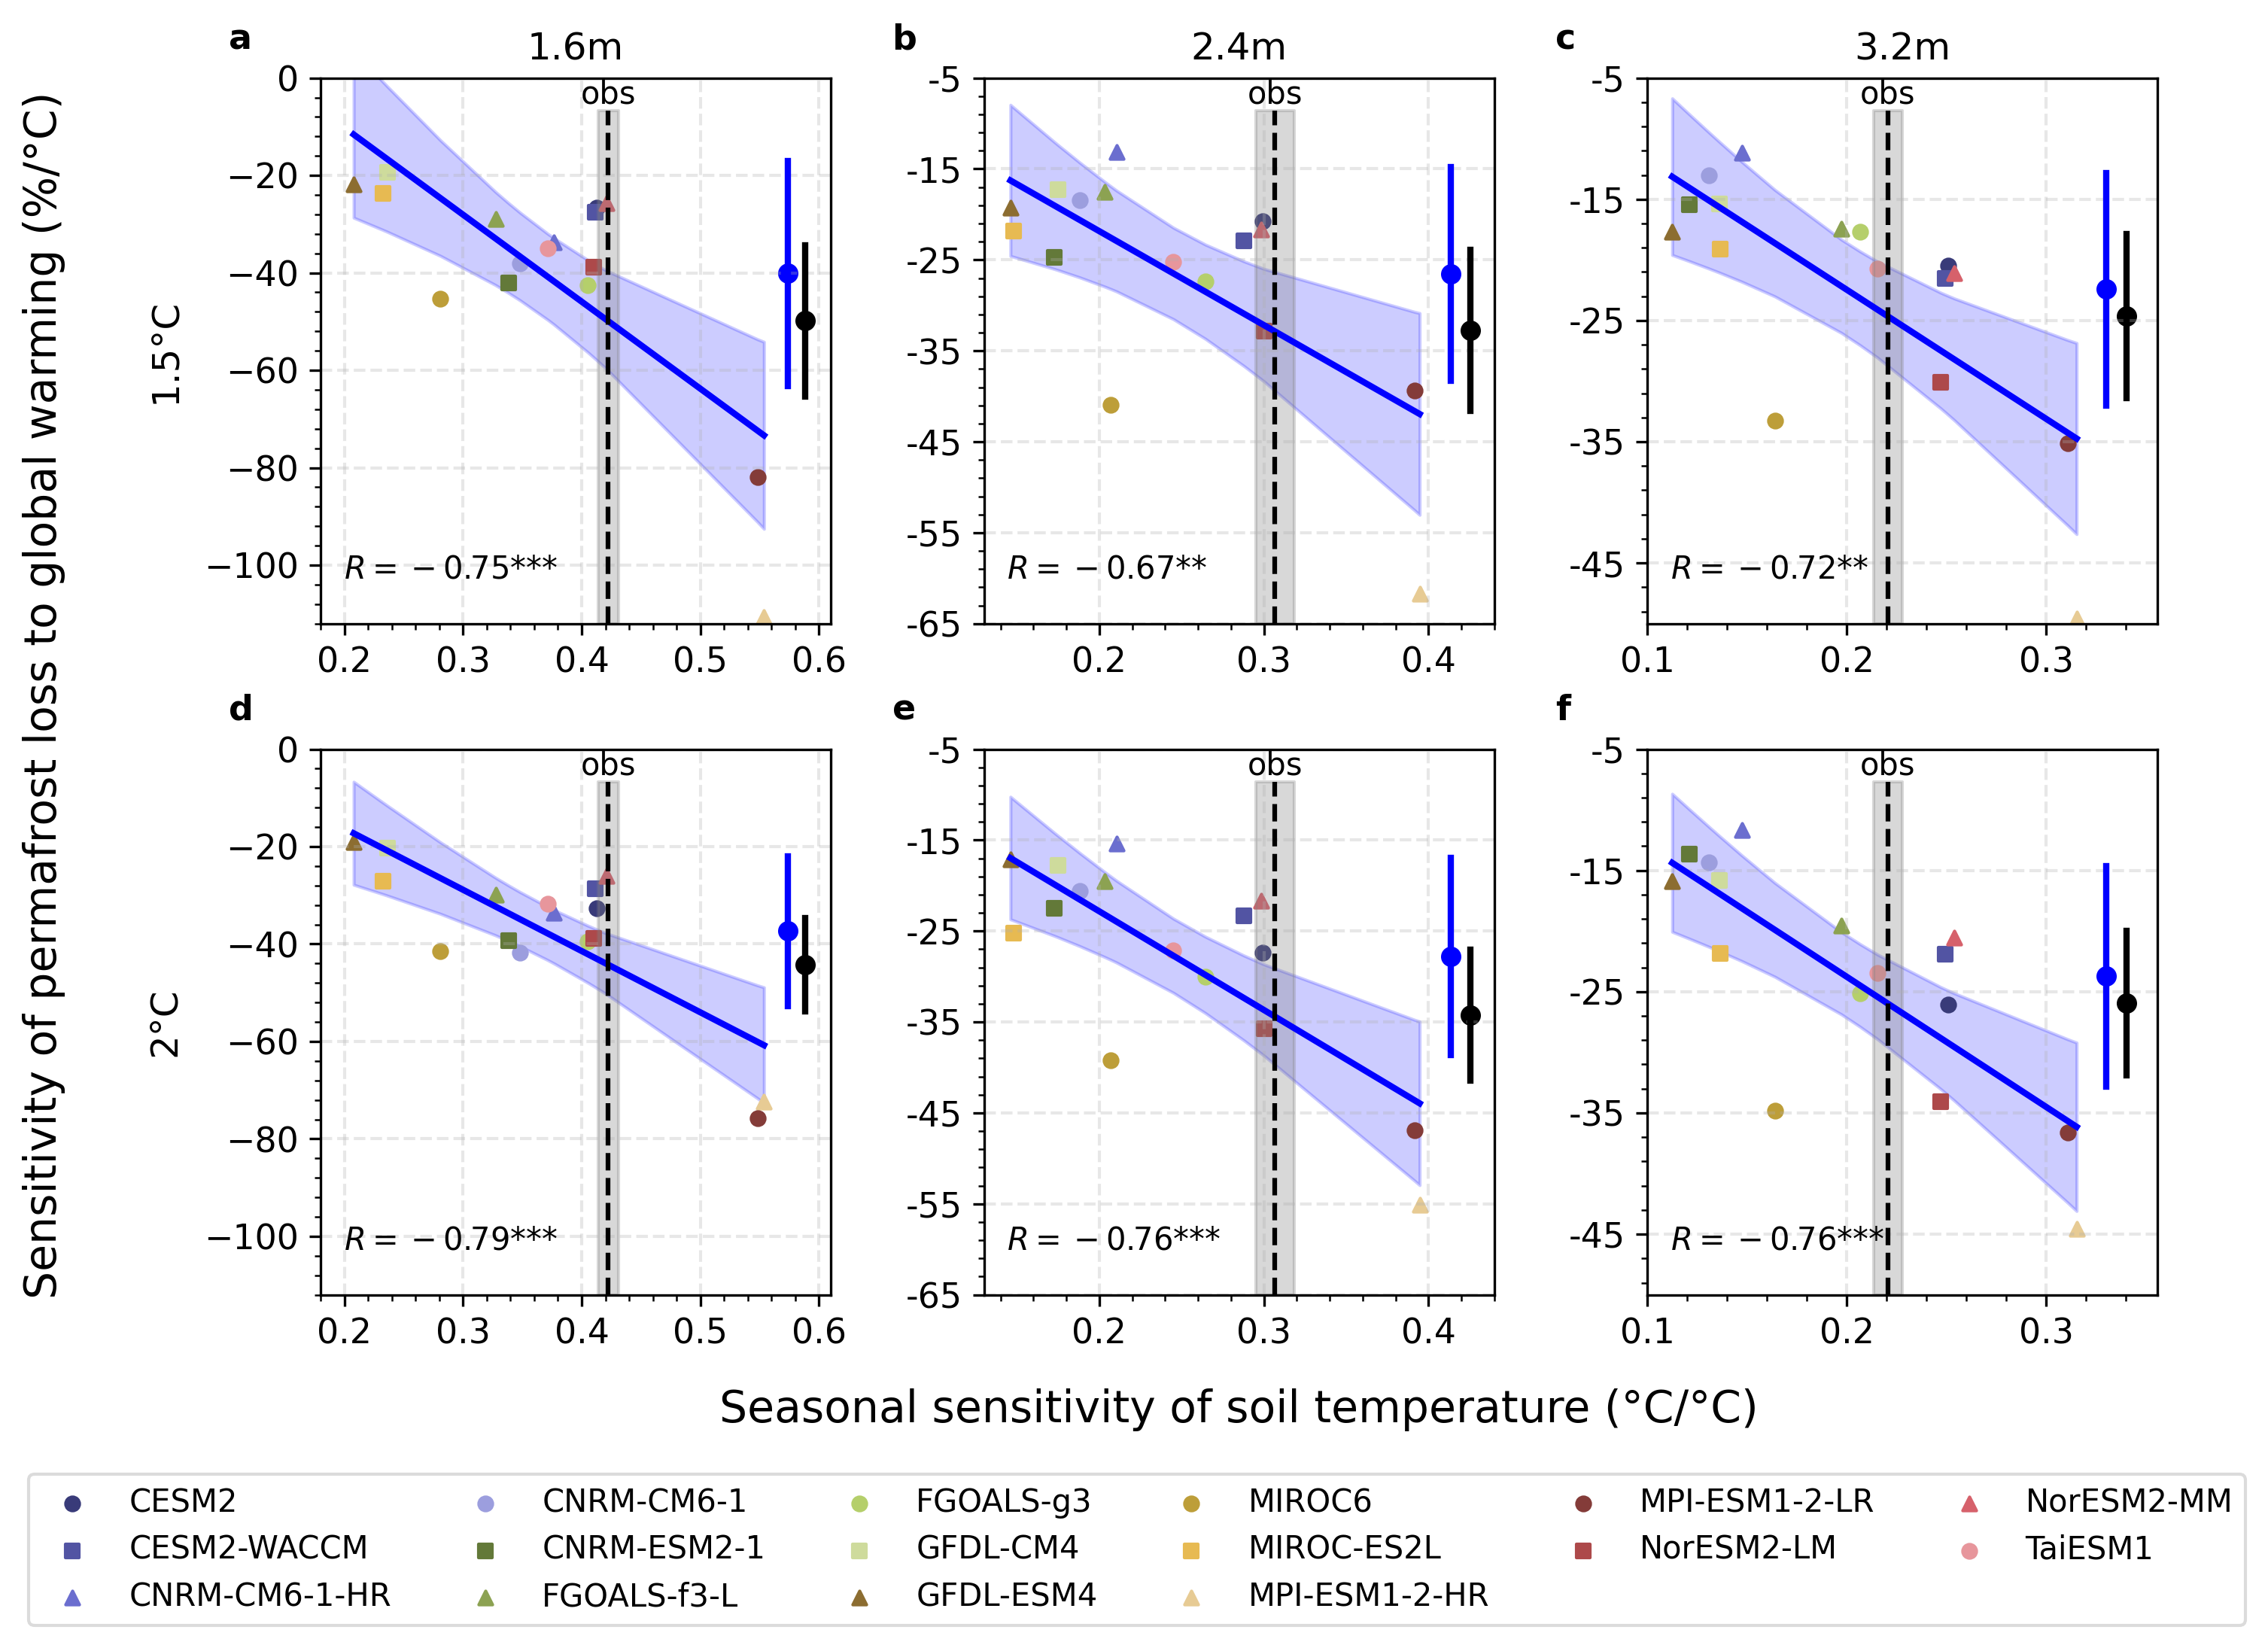

In [5]:
model_order = ["CESM2","CESM2-FV2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1",
               "E3SM-1-1","FGOALS-f3-L","FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6",
               "MIROC-ES2L","MPI-ESM1-2-HR","MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1"]
depths = ['160cm', '240cm', '320cm']

# Set up the plot
fig, axs = plt.subplots(2, 3, figsize=(10.5, 7), dpi=300)
fig.subplots_adjust(wspace=0.3, hspace=0.23) 

# Define excluded models as a set for faster lookup
excluded_models = {
    "KACE-1-0", "CanESM5", "CanESM5-CanOE", "IPSL-CM6A-LR",
    "CAS-ESM2-0","CMCC-CM2-SR5", "CMCC-ESM2",
    "CESM2-FV2","E3SM-1-1"
}

model16 = ["CESM2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1","FGOALS-f3-L",
               "FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L","MPI-ESM1-2-HR",
               "MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1"]

# Function to read and filter data from a file
def read_data_file_sorted(path, model_filter):
    model = [line.strip() for line in model_order]
    with open(path) as file:
        data_lines = file.readlines()
    obs = float(data_lines[-2])
    std = float(data_lines[-1])
    Ts_dt = [float(data_lines[model.index(flag)].strip()) for flag in model_filter if flag in model]
    return Ts_dt,obs,std

# Process each depth
a = 0
for depth in depths:

    # Read sensitivity data from CSV file
    file_path = "../Data/Permafrost_sensitivity/" + depth + "_permafrost_sensitivity_under_climate_change_ssp245.csv"
    pfarea_dt = pd.read_csv(file_path).set_index('model')
    pfarea_dt = pfarea_dt.reindex(model_order)
    pfarea_dt3, pfarea_dt2, pfarea_dt15 = pfarea_dt['3'], pfarea_dt['2'], pfarea_dt['1.5']
    
    # Read temperature data (sorted by model order)
    Ts_path = f"../Data/Ts_seasonal_sensitivity/Ts"+depth+"_Ts02_all_station_avg_obs_18model.txt"
    Ts_dt,obs,std = read_data_file_sorted(Ts_path, model16)

    # Filter out excluded models
    midx = [model not in excluded_models for model in model_order]
    
    # Plot sensitivity for each depth
    for i, pfarea in enumerate([pfarea_dt15, pfarea_dt2]):
        plot_sensitivity(obs, std, 
                        Ts_dt, 
                        pfarea[midx], model16, i, a)
    a += 1

plt.show()


In [40]:
fig.savefig("../Figures/FigureS8.png", bbox_inches='tight',dpi=300)